In [1]:
import glob
import os, sys
import inspect
currentdir = os.path.dirname(os.path.abspath(os.getcwd()))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, currentdir) 

import torch
import torch.nn as nn
import pandas
import numpy as np
import numpy.ma as ma
import pickle
import time

# import proplot as pplt
import seaborn as sns
import sklearn
import re 
from fractions import Fraction
import scipy.stats as st

device = 'cpu'
from utils import *
from plotting_functions import *

sns.set_context("poster", font_scale = .5, rc={"grid.linewidth": 5})

C:\Users\abel_\anaconda3\envs\CIT_\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
exp_list = glob.glob(currentdir+"\\experiments\\poisson_clicks\\perfect_model\\exp*8288") 
exp_list = sorted(exp_list, key = lambda x: int(x[-10:]))
exp_path = exp_list[0]

with open(exp_path + '\\training_kwargs.pickle', 'rb') as handle:
    training_kwargs = pickle.load(handle)

training_kwargs['exp_path'] = exp_path
training_kwargs['training_weights_path'] = exp_path+'/training/'
training_kwargs['figures_path'] = exp_path + '//figures/'
training_kwargs['device'] = device
training_kwargs['N_in'] = 4
training_kwargs['N_out'] = 2
training_kwargs['N_rec'] = 4

perfect_path = currentdir + "//experiments//poisson_clicks//perfect_model//perfect_weights_v2.pth"

rnn_model = RNNModel(training_kwargs['N_in'], training_kwargs['N_out'], training_kwargs['N_rec'], n_layers=1, transform_function='relu').to(device)
# rnn_model = load_model(rnn_model, training_kwargs).to(device)
rnn_model.load_state_dict(torch.load(perfect_path))

<All keys matched successfully>

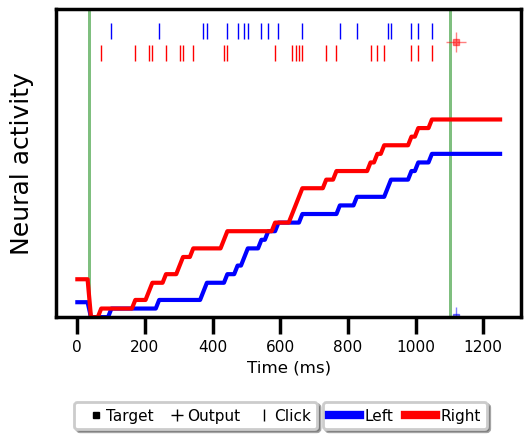

In [3]:
N_test_batch = 10**2
training_kwargs['fixed_cue_onsetandduration'] = [5,1,5,1]
training_kwargs['sum_of_rates'] = 40
training_kwargs['target_withcue'] = False
training_kwargs['equal_clicks'] = False
training_kwargs['ratios'] = [1]
training_kwargs['fixed_stim_duration_list'] = [100]
training_kwargs['T'] = 1250
training_kwargs['hidden_initial_variance'] = 4
pd = PoissonClicks(N_batch=N_test_batch, training_kwargs=training_kwargs)

normal_x, normal_y, normal_output_mask, normal_trial_params = pd.get_trial_batch() #generate self.N_batch trials

yhat, hidden_states = run_model_chunked(normal_x, rnn_model, hidden_initial_variance=training_kwargs['hidden_initial_variance'], n_chunks=1)
yhat = yhat.cpu().detach().numpy()
hidden_states = hidden_states.cpu().detach().numpy()

trial_i = 0
fig = plot_trial(trial_i, x=normal_x, y=normal_y, yhat=yhat,
           training_kwargs=training_kwargs, showoutput = "part", maxT="full");

maxT = training_kwargs['T']
times = np.linspace(0, maxT, int(maxT/training_kwargs['dt']))
plt.plot(times, hidden_states[trial_i, :, 0]/np.max(hidden_states), color='b')
plt.plot(times, hidden_states[trial_i, :, 1]/np.max(hidden_states), color='r')
plt.ylabel('Neural activity', fontsize=18)
plt.yticks([])
plt.savefig(currentdir+"/PoissonClicks/figs/task_pi_v1.pdf", bbox_inches="tight");
plt.savefig(currentdir+"/PoissonClicks/figs/task_pi_v1.png", bbox_inches="tight");

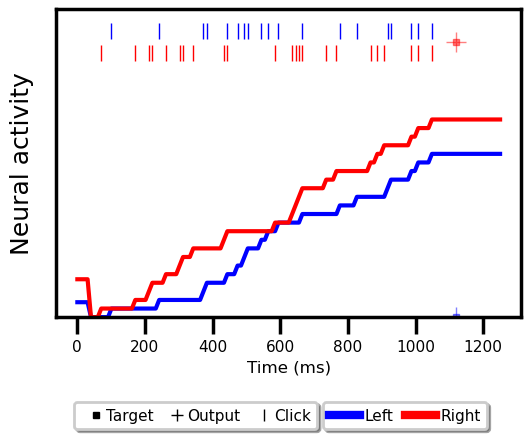

In [4]:
maxT = training_kwargs['T']
plot_trial(trial_i, x=normal_x, y=normal_y, yhat=yhat,
           training_kwargs=training_kwargs, showoutput = "part", maxT="full", plot_cues=False);
times = np.linspace(0, maxT, int(maxT/training_kwargs['dt']))
plt.plot(times, hidden_states[trial_i, :, 0]/np.max(hidden_states), color='b')
plt.plot(times, hidden_states[trial_i, :, 1]/np.max(hidden_states), color='r')
plt.ylabel('Neural activity', fontsize=18)
plt.yticks([])
plt.savefig(currentdir+"/PoissonClicks/figs/task_pi_cueless_v1.pdf", bbox_inches="tight");
plt.savefig(currentdir+"/PoissonClicks/figs/task_pi_cueless_v1.png", bbox_inches="tight");

(0.0, 0.72875)

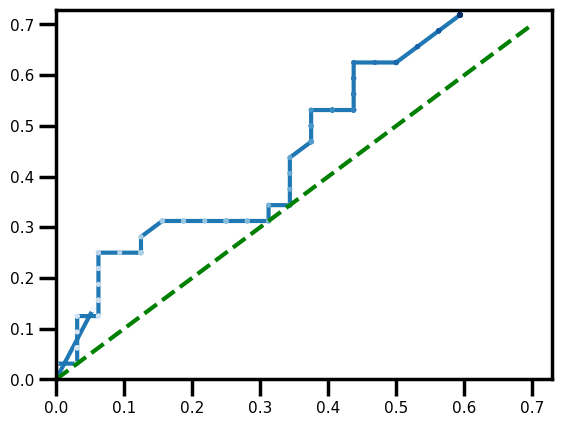

In [5]:
cmap = plt.get_cmap('Blues')
plt.plot(hidden_states[trial_i, :, 0]/np.max(hidden_states), hidden_states[trial_i, :, 1]/np.max(hidden_states))
plt.scatter(hidden_states[trial_i, :, 0]/np.max(hidden_states), hidden_states[trial_i, :, 1]/np.max(hidden_states), c=times, cmap=cmap, zorder=2, s=3)

plt.plot(np.arange(0, np.max(hidden_states[trial_i, :, 1])/np.max(hidden_states), .02), np.arange(0, np.max(hidden_states[trial_i, :, 1])/np.max(hidden_states), .02), 'g--')
plt.xlim([0,0.01+np.max(hidden_states[trial_i, :, 1])/np.max(hidden_states)])
plt.ylim([0,0.01+np.max(hidden_states[trial_i, :, 1])/np.max(hidden_states)])

In [6]:
np.arange(0, np.max(hidden_states[trial_i, :, 0])/np.max(hidden_states), .1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5])

C:\Users\abel_\AppData\Local\Temp\ipykernel_15856\720926805.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


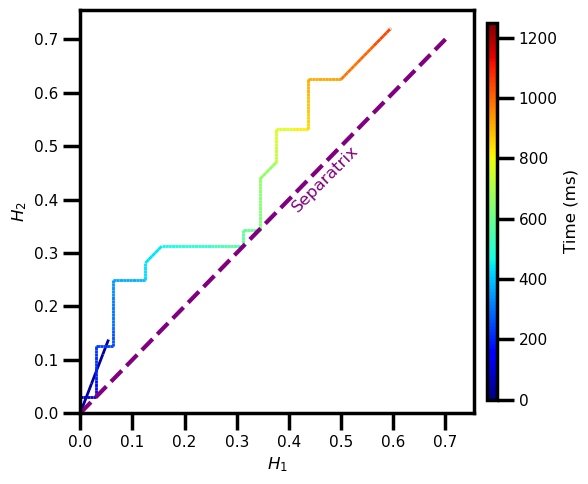

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.collections as mcoll
import matplotlib.path as mpath

def colorline(
    x, y, z=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0),
        linewidth=3, alpha=1.0):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha)

    ax = plt.gca()
    ax.add_collection(lc)

    return lc


def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments


x = hidden_states[trial_i, :, 0]/np.max(hidden_states)
y = hidden_states[trial_i, :, 1]/np.max(hidden_states)
fig, ax = plt.subplots(figsize=(5,5))

path = mpath.Path(np.column_stack([x, y]))
verts = path.interpolated(steps=5).vertices
x, y = verts[:, 0], verts[:, 1]
z = np.linspace(.0, 1., len(x))
cmap = plt.get_cmap('jet')
colorline(x, y, z, cmap=cmap, linewidth=2)
maxx = np.max([x,y])*1.05
sc = ax.scatter(hidden_states[trial_i, :,0]/np.max(hidden_states), hidden_states[trial_i, :,1]/np.max(hidden_states), s=.0001, marker='o',
                                cmap=cmap, norm=plt.Normalize(0.0, training_kwargs['T']),
                              c=np.linspace(0, training_kwargs['T'], hidden_states.shape[1]))
plt.plot(np.arange(0, np.max(hidden_states[trial_i, :, 1])/np.max(hidden_states), .02), np.arange(0, np.max(hidden_states[trial_i, :, 1])/np.max(hidden_states), .02), '--', color="purple")

matplotlib.pyplot.text(.4, .376, "Separatrix", rotation=45, color='purple')
plt.xlim([0,maxx])
plt.ylim([0,maxx])
plt.xlabel(r"$H_1$")
plt.ylabel(r"$H_2$")
cb_ax = fig.add_axes([.99,.185,.02,.754])
fig.colorbar(sc, cax=cb_ax, fraction=0.5, pad=0.0).set_label('Time (ms)',rotation=90)
plt.tight_layout()
plt.savefig(currentdir+"/PoissonClicks/figs/internalstates_pi_v1.pdf", bbox_inches="tight")
plt.savefig(currentdir+"/PoissonClicks/figs/internalstates_pi_v1.png", bbox_inches="tight")
plt.show()